# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [2]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt

# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two rules of thumb about the `display` argument:
* When doing development, turn the display on (`display=True`).
* When collecting data or saving a video, turn the display off (`display=False`).

If you are having trouble with the in-browser display — e.g., if it is running slowly on your laptop — then you can try the pybullet display instead (`display=False` and `display_pybullet=True`).

The `seed` argument (an integer, default `None`) initializes the random number generator that is used by the simulator.

In [3]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=True,
    seed=None,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


Choose a camera view from the following options:

* `camera_sideview()`
* `camera_scopeview()`
* `camera_catview()`

In [4]:
simulator.camera_scopeview()

Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently. This function will be called 25 times per second (i.e., at 25 Hz) by the simulator.

In [5]:
class Controller:
    def __init__(self, A, B, C, K, L, stars, dt = 0.04):
        # FIXME: add class variable names to this list (e.g., 'xhat')
        # if you want these variables to be logged by the simulator
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.dt = dt
        self.xhat = np.zeros(6)
        self.star_e = stars
        self.log = True

        # For logging
        self.t_log = []
        self.xhat_log = []

    
    def reset(self):
        self.xhat = np.zeros(6)
        self.t_log = []
        self.xhat_log = []
    
    def run(self, t, star_measurements):
        """
        The variable t is the current time.

        The variable star_measurements is a 1d array of length twice the
        number N of stars:

            [y_1, z_1, y_2, z_2, ..., y_N, z_N]
        
        The image coordinates y_i and z_i of the i'th star (for i = 1, ..., N)
        are at index 2 * i - 2 and 2 * i - 1 of this array, respectively.
        """
        u = -self.K @ self.xhat

        y = star_measurements - self.star_e

        #if self.log:
        #    print(y.tolist())
        #    self.log = False

        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )
        
        self.t_log.append(t)
        self.xhat_log.append(self.xhat.copy())

        torque_1, torque_2, torque_3, torque_4 = u
        
        return torque_1, torque_2, torque_3, torque_4
    
    def get_logs(self):
        return np.array(self.t_log), np.array(self.xhat_log)


Create an instance of the controller.

In [6]:

A = [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -0.0, 0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
B = [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-0.018530635807362836, 0.037061271614725715, -0.018530635807362836, -2.62041779934909e-18], [-0.032096002714907576, -4.538696765530462e-18, 0.032096002714907576, 0.0], [-0.0249042741960589, -0.0249042741960589, -0.0249042741960589, 0.0498085483921178]]
C = [[-2.73286481605181, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, -0.532113843210265, 0.0, 0.0, 0.0], [-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, -0.263378514224308, 0.0, 0.0, 0.0], [-2.73286481605181, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.625, 0.532113843210265, 0.0, 0.0, 0.0], [-2.625, 0.0, 0.532113843210265, 0.0, 0.0, 0.0], [0.0, 2.73286481605181, 0.0, 0.0, 0.0, 0.0], [-2.625, 0.0, -0.532113843210265, 0.0, 0.0, 0.0], [0.0, 2.73286481605181, 0.0, 0.0, 0.0, 0.0]]
K = [[-2.6726124191242517, -5.000000000000004, -2.8867513459481344, -7.217632087849548, -12.501305486494875, -5.550171449717585], [-2.67261241912425, -8.498609549814149e-15, 5.773502691896259, 14.435264175699114, -5.531005805371722e-15, -5.550171449717579], [-2.67261241912425, 5.0000000000000115, -2.88675134594812, -7.2176320878495535, 12.501305486494875, -5.550171449717582], [5.345224838248501, 6.894387940644665e-16, 1.5590659604934256e-15, 2.5405916712901594e-15, 2.0703884587222678e-15, 11.100342899435164]]

L = [[-0.5280192593161137, 4.827026059303848e-17, -0.5122843921038144, 4.3280728457207245e-17, -0.5280192593161137, 2.8511048950589926e-17, -0.5071786015772402, 3.9968178929936215e-17, -0.5071786015772402, 3.9968178929936215e-17], [-3.9968178929936215e-17, 0.49517912668591996, -3.877713527559205e-17, 0.5024691931911416, -3.9968178929936215e-17, 0.5240487607603784, 0.014434817037229177, 0.5305546729792006, -0.014434817037229253, 0.5305546729792006], [5.074032087268132e-17, -0.7504656413066011, 4.922826956554686e-17, -0.3354923073049541, 5.074032087268132e-17, 0.8928840173974253, 0.8216748293520132, 0.07413527031959005, -0.8216748293520132, 0.07413527031959005], [-3.1243294683791936e-17, -0.4485022000487561, -3.031225081664033e-17, -0.20203337175340705, -3.1243294683791936e-17, 0.5275471787258703, 0.48802468938731314, 0.04114652211661925, -0.48802468938731325, 0.04114652211661925], [-5.0379818659228364e-17, 0.43259203447229166, -4.887851024519551e-17, 0.43663816368171704, -5.0379818659228364e-17, 0.44861524490671234, 0.008011605217210263, 0.4587086418025938, -0.00801160521721036, 0.4587086418025938], [-0.45707743771946274, -2.1531165001437895e-16, -0.44345662245304834, -5.58111673819314e-17, -0.45707743771946274, 4.163314996057358e-16, -0.439036818420821, 1.0464001414785636e-16, -0.43903681842082165, 1.0464001414785636e-16]]

A = np.array(A)
B = np.array(B)
C = np.array(C)
K = np.array(K)
L = np.array(L)

stars = [0.5321138432102653, 0.0, 0.2633785142243077, 0.0, -0.5321138432102653, 0.0, 0.0, 0.5321138432102653, 0.0, -0.5321138432102653]

controller = Controller(A,B,C,K,L,stars)

You could reset the simulator with given initial conditions.

In [7]:
simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.1, #Test Recovory
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
    space_debris=False,      # <-- whether or not there is space debris
    docking_time=60        # <-- how long it takes for the space-cat to dock with the spacecraft
)

Or, you could reset the simulator with initial conditions sampled at random (in particular, each initial condition will be sampled from a normal distribution that has mean $\mu=0.0$ and standard deviation $\sigma = 0.05$).

In [8]:
if False:
    simulator.reset(
        initial_conditions=None,
        scope_noise=0.1 ,        # <-- standard deviation of each image coordinate of each star tracker measurement
        space_debris=False,      # <-- whether or not there is space debris
        docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
    )

Reset the controller.

In [9]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

If you create a video (i.e., if `video_filename` is not `None`), then — by default — the size of that video will be 640x480 pixels. You can change the size of the video by calling the following function **before** you call `simulator.run`:

```python
simulator.set_snapshot_size(
    320, # <-- width (example)
    240, # <-- height (example)
)
```

Both the width and height must be multiples of 16. One reason why you might want to change the size is to reduce the time it takes to create a video — a smaller size will take less time (but will be lower resolution). Another reason why you might want to change the size is to get a different aspect ratio — a square video, in particular, might be more appropriate if you wanted to use `camera_scopeview`, since the image captured by the star tracker is square.

In [10]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=60.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

Check if the space-cat has docked.

In [11]:
has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

The space-cat docked.


Get, show, and save a snapshot of the simulation after the last time step.

In [12]:
# # Set the width and height of the snapshot (must be multiples of 16)
# simulator.set_snapshot_size(
#     640, # <-- width
#     480, # <-- height
# )

# # Get snapshot as height x width x 4 numpy array of RGBA values
# rgba = simulator.snapshot()

# # Display snapshot
# plt.figure(figsize=(8, 8))
# plt.imshow(rgba)

# # Save snapshot
# plt.imsave('my_snapshot.png', rgba)

Get, show, and save a snapshot of the simulation from a side view, with a picture-in-picture view from the scope.

In [13]:
# # Get snapshot as height x width x 4 numpy array of RGBA values
# # with a picture-in-picture view of the scope
# rgba = simulator.pybullet_snapshot()

# # Display snapshot
# plt.figure(figsize=(8, 8))
# plt.imshow(rgba)

# # Save snapshot
# plt.imsave('my_snapshot.png', rgba)

Plot the results. (This code is meant only for development. You will want to create different and better plots for your own report.)

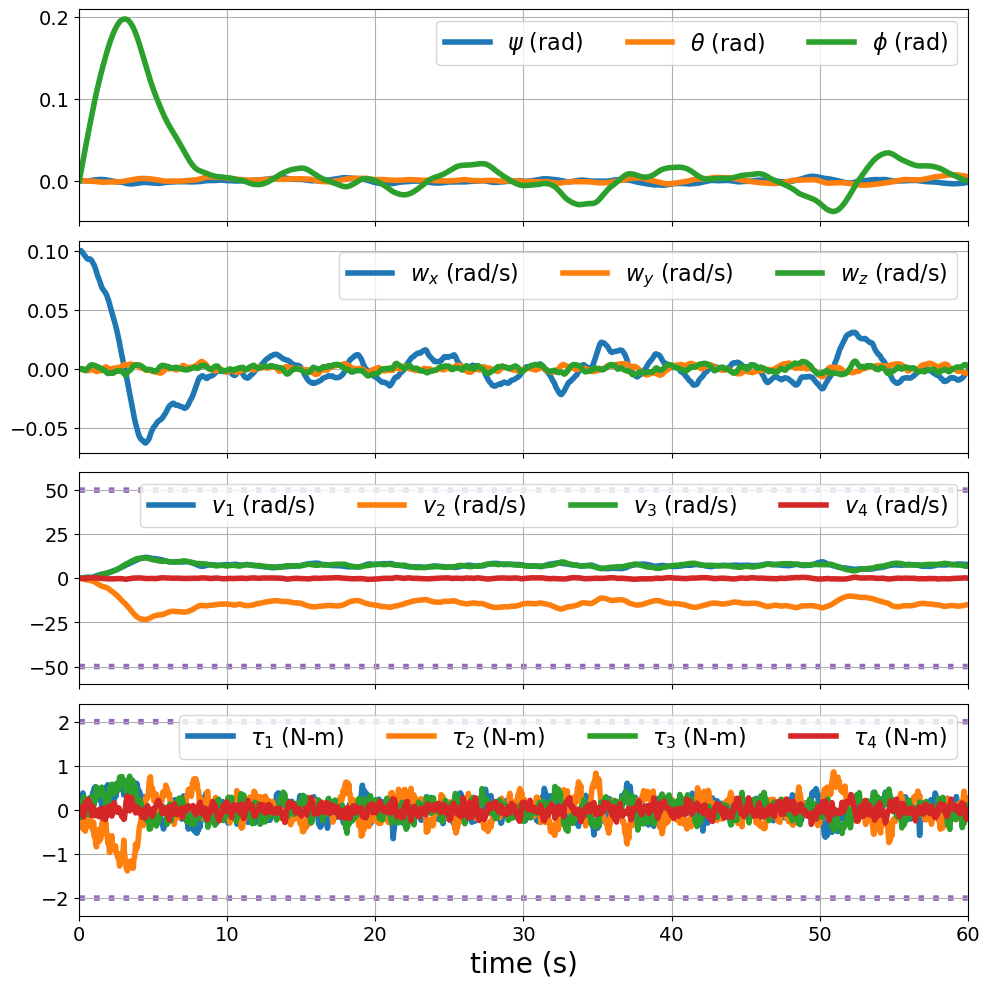

In [14]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['psi'], label=r'$\psi$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label=r'$\theta$ (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label=r'$\phi$ (rad)', linewidth=4)

ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

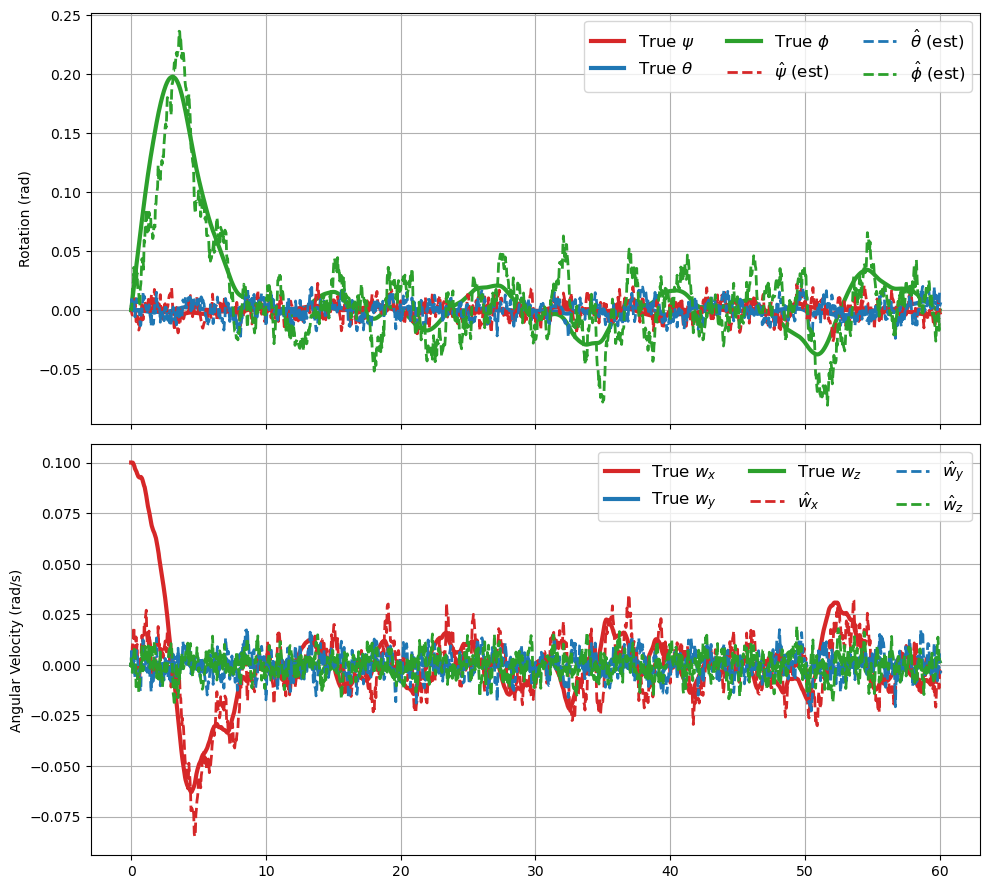

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Get logged estimates from the controller
t_est, xhat_log = controller.get_logs()

# Create figure with three subplots
fig, (ax_ori_est, ax_vel_est) = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

# Choose consistent colors for each component
color_psi = 'tab:red'
color_theta = 'tab:blue'
color_phi = 'tab:green'

color_wx = 'tab:red'
color_wy = 'tab:blue'
color_wz = 'tab:green'

# ---- 1. Plot Rotation Estimates vs True Rotation ----
ax_ori_est.plot(data['t'], data['psi'], label=r'True $\psi$', color=color_psi, linewidth=3)
ax_ori_est.plot(data['t'], data['theta'], label=r'True $\theta$', color=color_theta, linewidth=3)
ax_ori_est.plot(data['t'], data['phi'], label=r'True $\phi$', color=color_phi, linewidth=3)

ax_ori_est.plot(t_est, xhat_log[:, 0], '--', label=r'$\hat{\psi}$ (est)', color=color_psi, linewidth=2)
ax_ori_est.plot(t_est, xhat_log[:, 1], '--', label=r'$\hat{\theta}$ (est)', color=color_theta, linewidth=2)
ax_ori_est.plot(t_est, xhat_log[:, 2], '--', label=r'$\hat{\phi}$ (est)', color=color_phi, linewidth=2)

#ax_ori_est.set_ylim(-1, 1)
ax_ori_est.set_ylabel("Rotation (rad)")
ax_ori_est.legend(fontsize=12, ncol=3)
ax_ori_est.grid()

# ---- 2. Plot Angular Velocity Estimates vs True Angular Velocity ----
ax_vel_est.plot(data['t'], data['w_x'], label=r'True $w_x$', color=color_wx, linewidth=3)
ax_vel_est.plot(data['t'], data['w_y'], label=r'True $w_y$', color=color_wy, linewidth=3)
ax_vel_est.plot(data['t'], data['w_z'], label=r'True $w_z$', color=color_wz, linewidth=3)

ax_vel_est.plot(t_est, xhat_log[:, 3], '--', label=r'$\hat{w}_x$', color=color_wx, linewidth=2)
ax_vel_est.plot(t_est, xhat_log[:, 4], '--', label=r'$\hat{w}_y$', color=color_wy, linewidth=2)
ax_vel_est.plot(t_est, xhat_log[:, 5], '--', label=r'$\hat{w}_z$', color=color_wz, linewidth=2)

#ax_vel_est.set_ylim(-1, 1)
ax_vel_est.set_ylabel("Angular Velocity (rad/s)")
ax_vel_est.legend(fontsize=12, ncol=3)
ax_vel_est.grid()

fig.tight_layout()
plt.show()

What seems to be happening is that the $w_x$ inside of $\hat x$ is not velocity but actually accleration. I have no idea why, but this likely is the cause of the strange behavior of the simulation.

Save the figure (without transparent background).

In [16]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

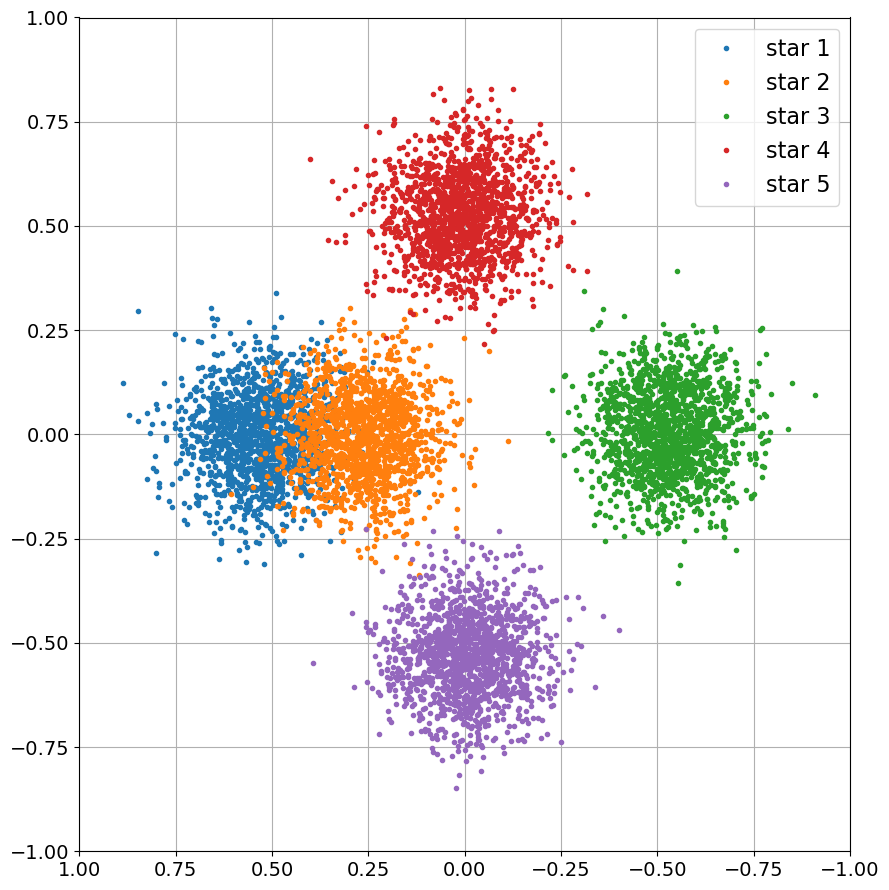

In [17]:
# Create a figure with one subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Scatter-plot the position of all stars at all time steps in the scope
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(y, z, label=f'star {i + 1}', linestyle='none', marker='.', markersize=6)

# Change appearance of axes
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(1., -1.) # <-- the "y_star" axis points left (not right)
ax.set_ylim(-1., 1.) # <-- the "z_star" axis points up

# Make the arrangement of subplots look nice
fig.tight_layout()

In [22]:
simulator_f = ae353_spacecraft_simulate.Simulator(
    display=False,
    seed=None,
)

num_simulations = 10
successful_landings = 0
failed_landings = 0

for i in range(num_simulations):
    print("Sim:",i+1, "of", num_simulations)
    simulator_f.reset(
        initial_conditions=None,
        scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
        space_debris=True,      # <-- whether or not there is space debris
        docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
    )
    
    controller.reset()  # Reset controller
    
    # Run simulation
    data = simulator_f.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=60.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
    )
    
    # Check if the aircraft has landed
    if simulator_f.has_docked():
        successful_landings += 1
    else:
        failed_landings += 1

Sim: 1 of 10
Sim: 2 of 10
STOPED DUE TO WHEEL EXCEDING MAX VELOCITY
Sim: 3 of 10
STOPED DUE TO STAR OUT OF VIEW
Sim: 4 of 10
STOPED DUE TO STAR OUT OF VIEW
Sim: 5 of 10
STOPED DUE TO STAR OUT OF VIEW
Sim: 6 of 10
Sim: 7 of 10
Sim: 8 of 10
STOPED DUE TO STAR OUT OF VIEW
Sim: 9 of 10
Sim: 10 of 10
STOPED DUE TO STAR OUT OF VIEW


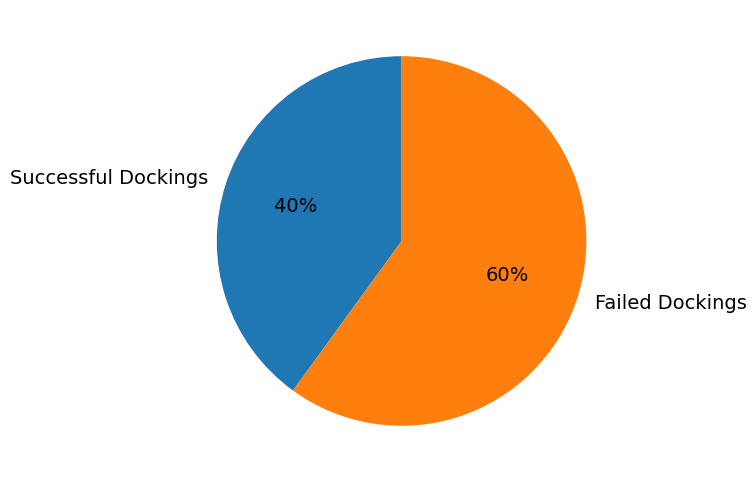

In [21]:
labels = ['Successful Dockings', 'Failed Dockings']
sizes = [successful_landings, failed_landings]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90,textprops={'fontsize': 14})
#plt.title('Docking Outcomes',fontsize=16)
plt.show()